In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import gseapy as gp
from gseapy import gseaplot
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib_venn import venn2, venn2_circles
from scipy.stats import ranksums, pearsonr, spearmanr
from statsmodels.stats.multitest import multipletests
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn import preprocessing
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance

import xgboost as xgb
from sklearn import metrics
plt.rcParams['pdf.fonttype'] = 42

In [2]:
DF = pd.read_csv('result_datasets/Robinson_genes_features.csv', index_col=0)

In [3]:
DF

,Label,geneLen,GC_content,median_IUPRED,5UTR_PARS_RNAstructure,CDS_PARS_RNAstructure,3UTR_PARS_RNAstructure,%AA_A,%AA_C,%AA_D,...,ASAquick_buried,DisoRDPbind_RNA,DisoRDPbind_DNA,DisoRDPbind_PRO,MoRFchibi_morf,DRNApred_RNA,DRNApred_DNA,SCRIBER_PRO,PTM_content,haploinsufficient
YAL002W,0,3825.0,37.1765,0.0719,NaN,NaN,NaN,0.0392,0.0204,0.0541,...,0.474,0.000,0.000,0.000,0.0,0.000,0.00,0.000,0.035,0
YAL003W,1,621.0,44.6055,0.3494,-0.715385,1.217176,0.303319,0.1546,0.0048,0.1063,...,0.170,0.000,0.010,0.068,0.0,0.015,0.00,0.000,0.073,0
YAL005C,1,1929.0,44.0643,0.3807,0.660469,1.003508,-0.125213,0.0933,0.0047,0.0762,...,0.382,0.000,0.000,0.065,0.0,0.002,0.00,0.000,0.053,0
YAL007C,0,648.0,37.0370,0.0632,0.536046,0.494137,-0.035873,0.0741,0.0093,0.0556,...,0.274,0.000,0.000,0.000,0.0,0.000,0.05,0.000,0.051,0
YAL009W,0,780.0,41.4103,0.0690,-0.191923,0.069565,0.032087,0.0615,0.0077,0.0462,...,0.232,0.000,0.000,0.066,0.0,0.000,0.02,0.012,0.081,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YPR192W,0,918.0,51.0893,0.0281,NaN,NaN,NaN,0.1307,0.0261,0.0359,...,0.413,0.000,0.000,0.010,0.0,0.000,0.00,0.007,0.043,0
YPR196W,0,1413.0,38.8535,0.0414,NaN,NaN,NaN,0.0467,0.0382,0.0701,...,0.370,0.087,0.000,0.000,0.0,0.000,0.00,0.000,0.032,0
YPR199C,0,885.0,38.9831,0.1852,0.130769,0.075395,0.073654,0.0508,0.0271,0.0441,...,0.241,0.000,0.017,0.000,0.0,0.000,0.00,0.000,0.068,0
YPR200C,0,393.0,37.6590,0.1759,NaN,NaN,NaN,0.0458,0.0229,0.0458,...,0.185,0.015,0.000,0.000,0.0,0.000,0.02,0.000,0.023,0


# Cleaning up the dataset and imputing what's needed

In [4]:
gene_name = pd.read_csv('datasets/Yeast_gene_mapped_ORF_name.table', sep= '\t', index_col=1)
DF = DF.join(gene_name)
DF = DF.rename_axis('Systematic name').reset_index()
DF['Gene'] = DF['Gene'].fillna(DF['Systematic name'])
DF = DF.set_index('Gene')

In [5]:
# delete columns with too much to impute
# delete ['RNAseq RPKM', 'MS mean', 'log2(MS)', 'RNAseq RPKM', 'Sum d0 Pause Score', 'intron length']
# delete redundant features
df_short = DF.copy()
df_short = df_short.drop(['5UTR_PARS_RNAstructure', 'CDS_PARS_RNAstructure', 'median transcript length', 'log2(MS)', 
                          'MS mean', 'intron length','Sum d0 Pause Score', 'Introns median length',
'3UTR_PARS_RNAstructure', 'Ribo_profilling_ribo_num', 'Ribo_profilling_trans_time', 'protein_synthesis_rate', 
'real_protein_synthesis_rate','Ribo_profilling_delay_time', 'Control Median', 'Sum Odds Ratio',], axis=1)
df_short = df_short.replace( 'Potential_AUG_annotation_error', np.nan)
# remove row with more than 6 nan values
df_short = df_short.dropna(thresh=df_short.shape[1]-6)

# Fill na with median of each column
DF_imputed = df_short.copy()
feat = ['median_IUPRED', 'Ribo_profilling_init_rate', 'Ribo_profilling_trans_rate', 'cai',
       "5'-UTR_length", "3'-UTR_length", 'protein half-life (hr)', 'mRNA half-life (min)', 'alpha IDRratio', 'A3D mean score', 'A3D ratio', 
        'A3D mean +score', 'flDPnn_disorder',
       'PSIPRED_helix', 'PSIPRED_strand', 'PSIPRED_coil',
       'MMseq2_low_conservation', 'MMseq2_high_conservation', 'MMseq2_median',
       'SignalP', 'DFLpred_linker', 'ASAquick_buried', 'DisoRDPbind_RNA',
       'DisoRDPbind_DNA', 'DisoRDPbind_PRO', 'MoRFchibi_morf', 'DRNApred_RNA',
       'DRNApred_DNA', 'SCRIBER_PRO', 'PTM_content']
DF_imputed[feat] = DF_imputed[feat].fillna(value=DF_imputed[feat].median())
,
# Imputation of missing values 
DF_imputed['RNAseq Eupl'] = DF_imputed['RNAseq Eupl'].fillna(0)
DF_imputed['Ubiquitilation number'] = DF_imputed['Ubiquitilation number'].fillna(0)
DF_imputed['Phosphorylation number'] = DF_imputed['Phosphorylation number'].fillna(0)

DF_imputed['number of physical interaction'] = DF_imputed['number of physical interaction'].fillna(0)
DF_imputed['number of positive genetic interaction'] = DF_imputed['number of positive genetic interaction'].fillna(0)
DF_imputed['number of negative genetic interaction'] = DF_imputed['number of negative genetic interaction'].fillna(0)

DF_imputed[['number of physical interaction',
       'number of positive genetic interaction',
       'number of negative genetic interaction', 'number of ppi, all',
       'number of ppi, score >= 0.25', 'number of ppi, score > 0.5',
       'number of ppi, score > 0.8', 'number of ppi, score >= 0.95', 'rna logFC', 'rna FC - other']] = DF_imputed[['number of physical interaction',
       'number of positive genetic interaction',
       'number of negative genetic interaction', 'number of ppi, all',
       'number of ppi, score >= 0.25', 'number of ppi, score > 0.5',
       'number of ppi, score > 0.8', 'number of ppi, score >= 0.95', 'rna logFC', 'rna FC - other']].fillna(0)

# Since positive and negative interactio are correlated, sum them up
DF_imputed['number of genetic interaction'] = DF_imputed['number of positive genetic interaction'] + DF_imputed['number of negative genetic interaction']
DF_imputed = DF_imputed.drop(['number of positive genetic interaction',
       'number of negative genetic interaction'], axis=1)

DF_imputed["5'-UTR_length"] = DF_imputed["5'-UTR_length"].astype('float')

# Normalize most features to 'gene length'
to_norm = ['Phosphorylation number', 'Ubiquitilation number']

for x in to_norm:
    DF_imputed[x] = DF_imputed[x]/DF_imputed['geneLen']*np.mean(DF_imputed['geneLen'])
    DF_imputed = DF_imputed.rename(columns={x: x + ' norm_geneLen'})
# drop categorical    'GOMF', 'GOBP slim','GOCC slim'
DF_imputed.drop(['haploinsufficient', 'Intron status',
                'is in complex', 'is essential'], inplace=True, axis=1)
# drop highly correlated features
DF_imputed.drop(['control Localization', 'Ribo_profilling_trans_rate', 'molecularWeight','ORF.length',  'MMseq2_median', 'number of ppi, all',
       'number of ppi, score >= 0.25', 'number of ppi, score > 0.5', 'number of ppi, score >= 0.95', 'A3D mean +score'], inplace=True, axis=1)

In [6]:
DF_imputed.drop('Systematic name', axis=1, inplace=True)

# Over-representation analysis (hypergeometric test)

## loading yeast gene ontology for gseapy

In [7]:
yeast =gp.get_library_name(organism='Yeast')
# download library or read a .gmt file
go_mf = gp.get_library(name='GO_Molecular_Function_2018', organism='Yeast')
go_bp = gp.get_library(name='GO_Biological_Process_2018', organism='Yeast')
go_cc = gp.get_library(name='GO_Cellular_Component_2018', organism='Yeast')
kegg = gp.get_library(name='KEGG_2019', organism='Yeast')
pheno = gp.get_library(name='Phenotype_AutoRIF', organism='Yeast')
phenoZ = gp.get_library(name='Phenotype_AutoRIF_Predicted_zscore', organism='Yeast')
pfam = gp.get_library(name='Pfam_Domains_2019', organism='Yeast')
ppi = gp.get_library(name='PPI_Hubs_BioGRID_2018', organism='Yeast')
inter_hub = gp.get_library(name='Gene_Interaction_Hubs_BioGRID_2018', organism='Yeast')
interpro = gp.get_library(name='InterPro_Domains_2019', organism='Yeast')
geneHubs = gp.get_library(name='Gene_Interaction_Hubs_BioGRID_2018', organism='Yeast')
wiki = gp.get_library(name='WikiPathways_2018', organism='Yeast')

In [8]:
# Other lists
prions = []
with open('datasets/prions_yeast_22_pRANK.fasta') as file:
    for line in file:
        if line[0] == '>':
            line = line.strip('>')
            gene , _ = line.split(' ')
            prions.append(gene.upper())
intron = DF[DF['Intron status'] == 1]           
in_complex = DF[DF['is in complex'] == 1]
essential = DF[DF['is essential'] == 1]
transMB = DF[DF['has transmembrane domain'] ==1]
disordered = DF[DF['has disordered region'] ==1]
haploinf = DF[DF['haploinsufficient'] == 1]
other_libraries = {'Complexes': list(in_complex.index), 'essential genes': list(essential.index), 
                   'Transmembrane': list(transMB.index), 'Disordered': list(disordered.index), 'prions': prions, 
                   'happloinsufficient': list(haploinf.index), 'Intron': list(intron.index)}

In [9]:
libr = [go_bp, go_cc, go_mf, pfam, kegg, interpro, wiki, other_libraries]
name_libr = ['GOBP', 'GOCC', 'GOMF', 'PFAM', 'KEGG', 'INTER-PRO',  'Wiki pathway', 'Other']

dic_name_libr = {}
for x in range(len(name_libr)):
    dic_name_libr[name_libr[x]] = libr[x]
    
enrichments = []
for x in range(len(libr)): 
    enr2 = gp.enrich(gene_list=list(DF[DF.Label == 1].index), # or gene_list=glist
                 gene_sets= libr[x], 
                 background=list(DF_imputed.index), 
                 outdir= None, # 'GSEA_results/Fisher_' + name_libr[x],
                 verbose=False)
    enrichments.append(enr2)
# make a dataframe from significant enrichment
combined_fisher = enrichments[0].res2d[enrichments[0].res2d['Adjusted P-value']<=0.05]
combined_fisher['Ontology'] = name_libr[0]
for x in range(1, len(libr)):
    tmp = enrichments[x].res2d[enrichments[x].res2d['Adjusted P-value']<=0.05]
    tmp['Ontology'] = name_libr[x]
    combined_fisher = pd.concat([combined_fisher, tmp], axis=0) 
# add the features to dataset
df = DF_imputed.copy()
for i, row in combined_fisher.iterrows():
    t = row['Term']
    df[t] = 0
    genes = dic_name_libr[row['Ontology']][t]
    df.loc[df.index.isin(genes), t] = 1

C:\Users\user\AppData\Local\Temp\ipykernel_14264\117682402.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_fisher['Ontology'] = name_libr[0]
C:\Users\user\AppData\Local\Temp\ipykernel_14264\117682402.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['Ontology'] = name_libr[x]
C:\Users\user\AppData\Local\Temp\ipykernel_14264\117682402.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [10]:
df

,Label,geneLen,GC_content,median_IUPRED,%AA_A,%AA_C,%AA_D,%AA_E,%AA_F,%AA_G,...,Ribosomal protein L7Ae/L30e/S12e/Gadd45,Cytoplasmic Ribosomal Proteins_WP210,Glycolysis_WP253,Nutrient control of ribosomal gene expression_WP2869,Translation Factors_WP32,Disordered,Intron,essential genes,happloinsufficient,prions
Gene,,,,,,,,,,,,,,,,,,,,,
VPS8,0,3825.0,37.1765,0.0719,0.0392,0.0204,0.0541,0.0627,0.0463,0.0353,...,0,0,0,0,0,0,0,0,0,0
EFB1,1,621.0,44.6055,0.3494,0.1546,0.0048,0.1063,0.1063,0.0483,0.0290,...,0,0,0,0,1,0,1,1,0,0
SSA1,1,1929.0,44.0643,0.3807,0.0933,0.0047,0.0762,0.0793,0.0435,0.0778,...,0,0,0,0,0,1,0,0,0,0
ERP2,0,648.0,37.0370,0.0632,0.0741,0.0093,0.0556,0.0602,0.0509,0.0370,...,0,0,0,0,0,0,0,0,0,0
SPO7,0,780.0,41.4103,0.0690,0.0615,0.0077,0.0462,0.0500,0.0654,0.0423,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RPO26,0,468.0,40.5983,0.5215,0.0577,0.0000,0.0897,0.1346,0.0513,0.0577,...,0,0,0,0,0,1,1,1,1,0
MLC2,0,492.0,40.0407,0.3649,0.0427,0.0000,0.0854,0.1280,0.0671,0.0610,...,0,0,0,0,0,0,0,0,0,0
RPC82,0,1965.0,38.8804,0.2399,0.0595,0.0061,0.0504,0.0885,0.0244,0.0336,...,0,0,0,0,0,1,0,1,0,0


In [11]:
def CV_roc_curve(DF, num_F, cat_F, y_F, fig, ax, n_splits, model, color, label_name = None, linestyle='solid'):
    folds = StratifiedKFold(n_splits,shuffle=True,random_state=17)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    X = DF[num_F+cat_F]
    y = DF[y_F]
    
    for fold, (train_index, valid_index) in enumerate(folds.split(X, y)):
        X_train = X.iloc[train_index]
        X_valid = X.iloc[valid_index]
        y_train = y.iloc[train_index]
        y_valid = y.iloc[valid_index]
        # scaling
        scaler = preprocessing.StandardScaler().fit(X_train[num_F])
        X_train_s = pd.DataFrame(scaler.fit_transform(X_train[num_F]), columns=num_F, index = list(X_train.index))
        X_valid_s = pd.DataFrame(scaler.transform(X_valid[num_F]), columns=num_F, index = list(X_valid.index))

        # merge scaled numerical and categorical
        X_train = pd.concat([X_train_s, X_train[cat_F]], axis=1)
        X_valid = pd.concat([X_valid_s, X_valid[cat_F]], axis=1)

        # fitting
        model.fit(X_train, y_train)
            
        viz = RocCurveDisplay.from_estimator(model, X_valid, y_valid, name=f"ROC fold {fold}",alpha=0,
                lw=1, ax=ax, plot_chance_level=(fold == n_splits - 1))
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
      
        # same aucs calculation as train_model function
        y_pred_valid = model.predict_proba(X_valid)
        # retrieve just the probabilities for the positive class
        y_pred_valid = y_pred_valid[:, 1]
        f, t, thresholds = metrics.roc_curve(np.array(y_valid), y_pred_valid, pos_label=1)
        aucs.append(metrics.auc(f, t))
        

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr,mean_tpr,color=color, label= label_name + r", Mean ROC (AUC = %0.3f $\pm$ %0.3f)" % (mean_auc, std_auc),
        lw=2,alpha=0.8,  linestyle=linestyle)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color=color,
        alpha=0.1,
        label=r"$\pm$ std. dev.")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    return model, aucs

In [12]:
# function to get the coefficient of model across k-fold
def coefs_kfold(DF, num_F, cat_F, y_F, n_splits, model):
    folds = StratifiedKFold(n_splits,shuffle=True,random_state=17)
    X = DF[num_F+cat_F]
    y = DF[y_F]
    
    for fold, (train_index, valid_index) in enumerate(folds.split(X, y)):
        X_train = X.iloc[train_index]
        X_valid = X.iloc[valid_index]
        y_train = y.iloc[train_index]
        y_valid = y.iloc[valid_index]
        # scaling
        scaler = preprocessing.StandardScaler().fit(X_train[num_F])
        X_train_s = pd.DataFrame(scaler.fit_transform(X_train[num_F]), columns=num_F, index = list(X_train.index))
        X_valid_s = pd.DataFrame(scaler.transform(X_valid[num_F]), columns=num_F, index = list(X_valid.index))
        X_train_s = pd.concat([X_train_s, X_train[cat_F]], axis=1)
        X_valid_s = pd.concat([X_valid_s, X_valid[cat_F]], axis=1)

        # Back to dataframe
        X_train = pd.DataFrame(X_train_s, index=X_train.index, columns=X_train.columns)
        X_valid = pd.DataFrame(X_valid_s, index=X_valid.index, columns=X_valid.columns)

        # fitting
        model.fit(X_train, y_train)
            
        if fold == 0:
            tmp = pd.DataFrame(model.coef_[0], columns=[fold], index= list(X_train.columns))
        else:
            tmp[fold] = model.coef_[0]
            
    tmp['mean'] = tmp.mean(axis=1)
    tmp['std'] =tmp.std(axis=1)

    return tmp

In [13]:
# function to get the coefficient of model across k-fold
def permutation_importance_kfold(DF, num_F, cat_F, y_F, n_splits, model, n_repeats= 10, scoring= None):
    folds = StratifiedKFold(n_splits,shuffle=True,random_state=42, )
    X = DF[num_F+cat_F]
    y = DF[y_F]
    
    for fold, (train_index, valid_index) in enumerate(folds.split(X, y)):
        X_train = X.iloc[train_index]
        X_valid = X.iloc[valid_index]
        y_train = y.iloc[train_index]
        y_valid = y.iloc[valid_index]
        # scaling
        scaler = preprocessing.StandardScaler().fit(X_train[num_F])
        X_train_s = pd.DataFrame(scaler.fit_transform(X_train[num_F]), columns=num_F, index = list(X_train.index))
        X_valid_s = pd.DataFrame(scaler.transform(X_valid[num_F]), columns=num_F, index = list(X_valid.index))
        X_train_s = pd.concat([X_train_s, X_train[cat_F]], axis=1)
        X_valid_s = pd.concat([X_valid_s, X_valid[cat_F]], axis=1)

        # Back to dataframe
        X_train = pd.DataFrame(X_train_s, index=X_train.index, columns=X_train.columns)
        X_valid = pd.DataFrame(X_valid_s, index=X_valid.index, columns=X_valid.columns)

        # fitting
        model.fit(X_train, y_train)
        result = permutation_importance(model, X_train, y_train, n_repeats=n_repeats, random_state=42, scoring=scoring)
        
        if fold == 0:
            tmp = pd.DataFrame(result.importances_mean, columns=[fold], index= list(X_train.columns))
        else:
            tmp[fold] = result.importances_mean
            
    tmp['mean'] = tmp.mean(axis=1)
    tmp['std'] =tmp.std(axis=1)

    return tmp

In [14]:
def plot_coefs(coefs, display_fit = 10, dim = (8, 4), savefig= None):
    sns.set(font_scale=1)
    sns.set_style("whitegrid")

    coefs['colors'] = ['red' if float( x) < 0 else 'green' for x in coefs['mean']] 

    # Sort values from lowest to highest 
    coefs['abs mean'] = np.abs(coefs['mean'])
    coefs.sort_values('abs mean', inplace= True, ascending=False)

    tmp = coefs.head(display_fit)
    tmp.sort_values('mean', inplace=True)
    # Resets initial index in Dataframe to None 
    #tmp.reset_index(inplace=True) 

    # Draw plot 
    plt.figure(figsize=dim, dpi=80) 
    # Plotting the horizontal lines 
    plt.hlines(y=tmp.index, xmin=0, xmax=tmp['mean'], color=tmp.colors, alpha=0.5, linewidth=12) 
    plt.errorbar(x = tmp['mean'], y = tmp.index, xerr = tmp['std'], color='black', fmt='none', capsize=0)
    # Decorations 
    # Setting the labels of x-axis and y-axis 
    plt.gca().set(xlabel='Coefficients mean') 

    # Setting Date to y-axis 
    plt.yticks(tmp.index, fontsize=13) 
    plt.xticks(fontsize=13) 
 
    # Optional grid layout 
    plt.grid(linestyle='--', alpha=0.5) 
    plt.title('Logistic regression, 5-fold top features', fontsize= 14)
    plt.tight_layout()
    if savefig:
        plt.savefig(savefig)
    plt.show()       

In [15]:
def plot_FI(FI, f_display = 10, figsize = (8, 5), savefig=None):
    FI.sort_values('mean', inplace=True)
    FI = FI.tail(f_display)
    # Draw plot 
    plt.figure(figsize=figsize, dpi=80) 
    # Plotting the horizontal lines 
    plt.boxplot(
            FI[[0,1,2,3,4]].T,
            vert=False,
            labels=list(FI.index),
            widths= 0.8,
        patch_artist = True,
                boxprops=dict(color='black', facecolor = 'gold'),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                medianprops=dict(color='black')
        )
    plt.axvline(x=0, color="k", linestyle="--")

    # Decorations 
    # Setting the labels of x-axis and y-axis 
    plt.gca().set(xlabel='Mean feature importance') 

    # Setting Date to y-axis 
    plt.xticks(fontsize=13) 


    # Optional grid layout 
    plt.grid(linestyle='--', alpha=0.5) 
    plt.title('Logistic regression, 5-fold top features', fontsize= 14)
    # Displaying the Diverging Bar Chart 
    plt.tight_layout()
    if savefig:
        plt.savefig(savefig)
    plt.show() 

In [16]:
def CV_confusion(DF,  num_F, cat_F, y_F, model, n_splits, normalize='true', list_labels=['Neutral', 'DS']):
    folds = StratifiedKFold(n_splits,shuffle=True,random_state=17)
    y_comb = []
    pred_comb = []
    
    X = DF[num_F+cat_F]
    y = DF[y_F]
    
    for fold_n, (train_index, test_index) in enumerate(folds.split(X, y)):
        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]
        # scaling
        scaler = preprocessing.StandardScaler().fit(X_train[num_F])
        X_train_s = scaler.transform(X_train[num_F])
        X_test_s = scaler.transform(X_test[num_F])
        X_train_s = pd.DataFrame(scaler.fit_transform(X_train[num_F]), columns=num_F, index = list(X_train.index))
        X_test_s = pd.DataFrame(scaler.transform(X_test[num_F]), columns=num_F, index = list(X_test.index))
        
        X_train = pd.concat([X_train_s, X_train[cat_F]], axis=1)
        X_test = pd.concat([X_test_s, X_test[cat_F]], axis=1)

        # model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        y_comb += list(y_test)
        pred_comb += list(y_pred)

    cm = confusion_matrix(np.array(y_comb), np.array(pred_comb), normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list_labels)
    fig, ax = plt.subplots(figsize=(3.5,3.5))
    ax.grid(False)
    disp.plot(ax=ax, cmap= 'Blues')

# Wilcoxon test, numerical features

In [17]:
df.columns

Index(['Label', 'geneLen', 'GC_content', 'median_IUPRED', '%AA_A', '%AA_C',
       '%AA_D', '%AA_E', '%AA_F', '%AA_G',
       ...
       'Ribosomal protein L7Ae/L30e/S12e/Gadd45',
       'Cytoplasmic Ribosomal Proteins_WP210', 'Glycolysis_WP253',
       'Nutrient control of ribosomal gene expression_WP2869',
       'Translation Factors_WP32', 'Disordered', 'Intron', 'essential genes',
       'happloinsufficient', 'prions'],
      dtype='object', length=189)

In [18]:
num_list = ['geneLen', 'GC_content', 'median_IUPRED', '%AA_A', '%AA_C', '%AA_D',
       '%AA_E', '%AA_F', '%AA_G', '%AA_H', '%AA_I', '%AA_K', '%AA_L', '%AA_M',
       '%AA_N', '%AA_P', '%AA_Q', '%AA_R', '%AA_S', '%AA_T', '%AA_V', '%AA_W',
       '%AA_Y', '%Helical', '%Proteinturn', '%Beta-sheet', 'Acidic AA%',
       'Basic AA%', 'Polar AA%', 'Hydrophobic AA%', 'Charged AA%',
       'number of physical interaction', 'number of ppi, score > 0.8',
       'RNAseq Eupl', 'rna logFC', 'rna FC - other', 'Imputed log2(MS)',
       'Ribo_profilling_init_rate', 'IDR ratio', 'Number of complexe',
       'aliphaticIndex', 'aromaticityScore', 'cai', 'codonBias', 'gravyScore',
       'instabilityIndex', 'pI', "5'-UTR_length", "3'-UTR_length",
       'protein half-life (hr)', 'mRNA half-life (min)',
       'Ubiquitilation number norm_geneLen',
       'Phosphorylation number norm_geneLen', 'alpha IDRratio',
       'A3D mean score', 'A3D ratio', 
       'has disordered region', 'has transmembrane domain', 'flDPnn_disorder',
       'PSIPRED_helix', 'PSIPRED_strand', 'PSIPRED_coil',
       'MMseq2_low_conservation', 'MMseq2_high_conservation', 'SignalP',
       'DFLpred_linker', 'ASAquick_buried', 'DisoRDPbind_RNA',
       'DisoRDPbind_DNA', 'DisoRDPbind_PRO', 'MoRFchibi_morf', 'DRNApred_RNA',
       'DRNApred_DNA', 'SCRIBER_PRO', 'PTM_content',
       'number of genetic interaction']


pval = []
stat = []

for cat in num_list:
    rs = ranksums(list(df[df.Label == 1][cat]), list(df[df.Label == 0][cat]))
    pval.append(rs.pvalue)
    stat.append(rs.statistic)

num_ranksum = pd.DataFrame(list(zip(pval, stat)), index=num_list, columns=['p-value', 'Statistic'])
num_ranksum = num_ranksum.sort_values(by=['p-value'], ascending=True)
# fdr benjamini hochberg correction
corr = multipletests(np.array(num_ranksum['p-value']), alpha=0.05, method='fdr_bh')
num_ranksum['FDR bh'] = corr[1]
features = list(num_ranksum[num_ranksum['FDR bh'] <= 0.05].index)
df.drop(list(set(num_list)-set(features)), axis=1, inplace=True)

In [19]:
def plot_FI_coef_col(FI, coef, f_display = 12, savefig=None, c1 = 'green', c2 = 'red', figsize = (10, 4.5)):
    FI.sort_values('mean', inplace=True)
    coef = coef.rename(columns={'mean': 'coef'})
    FI = FI.join(coef['coef'])
    FI = FI.tail(f_display)
    colors = []
    for c in list(FI['coef']):
        if c > 0:
            colors.append(c1)
        else:
            colors.append(c2)
            
    # Draw plot 
    fig = plt.figure(figsize =figsize)
    ax = fig.add_subplot(111)
    # Plotting the horizontal lines 
    bp = ax.boxplot(
            FI[[0,1,2,3,4]].T,
            vert=False,
            labels=list(FI.index),
            widths= 0.8,
        patch_artist = True,
                boxprops=dict(color='black', alpha = 0.5),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                medianprops=dict(color='black'))
    
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_color(color)
       
    ax.axvline(x=0, color="k", linestyle="--")
    # Decorations 
    # Setting the labels of x-axis and y-axis 
    plt.gca().set(xlabel='Mean feature importance') 

    # Setting Date to y-axis 
    plt.xticks(fontsize=12) 
    # Optional grid layout 
    plt.grid(linestyle='--', alpha=0.5) 
    plt.title('Logistic regression, 5-fold top features', fontsize= 14)
    # Displaying the Diverging Bar Chart 
    plt.tight_layout()
    if savefig:
        plt.savefig(savefig)
    plt.show() 

In [20]:
X = df.copy()
y = df['Label']
n = list(set(num_list) & set(X.columns))
c = list(set(X.columns) - set(num_list))
c.remove('Label')
classifier = LogisticRegression(max_iter=500, penalty='l2', solver='newton-cholesky', class_weight='balanced')

coefs = coefs_kfold(X, n, c, 'Label', 5, classifier)

In [21]:
coefs

,0,1,2,3,4,mean,std
A3D mean score,-0.644087,-0.523007,-0.483034,-0.322167,-0.395201,-0.473499,0.110158
number of physical interaction,0.052609,-0.013249,0.089847,0.034006,0.106501,0.053943,0.042345
DisoRDPbind_PRO,0.048228,0.123021,0.112801,0.125581,0.119663,0.105859,0.029133
median_IUPRED,-0.551771,-0.765093,-0.476207,-0.897553,-0.593199,-0.656765,0.153219
flDPnn_disorder,0.058452,-0.263019,0.079730,-0.184047,-0.155716,-0.092920,0.137042
...,...,...,...,...,...,...,...
positive regulation of mitotic actomyosin contractile ring assembly (GO:1903501),0.884310,0.715957,0.784489,0.624128,0.779134,0.757604,0.085780
chaperone mediated protein folding requiring cofactor (GO:0051085),0.234754,0.162660,-0.129336,0.218269,0.221072,0.141484,0.137638
cytosolic ribosome (GO:0022626),0.257596,0.410581,0.400061,0.299461,0.177596,0.309059,0.087876
rRNA-containing ribonucleoprotein complex export from nucleus (GO:0071428),-0.289082,-0.758335,-0.629620,-0.816203,-0.026311,-0.503910,0.300770


C:\Users\user\AppData\Local\Temp\ipykernel_14264\2721363285.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp.sort_values('mean', inplace=True)


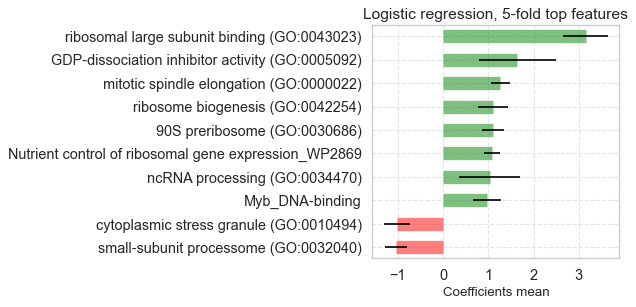

In [22]:
plot_coefs(coefs)

# Same thing with feature importance

In [23]:
FI = permutation_importance_kfold(X, n, c, 'Label', 5, classifier, 5)

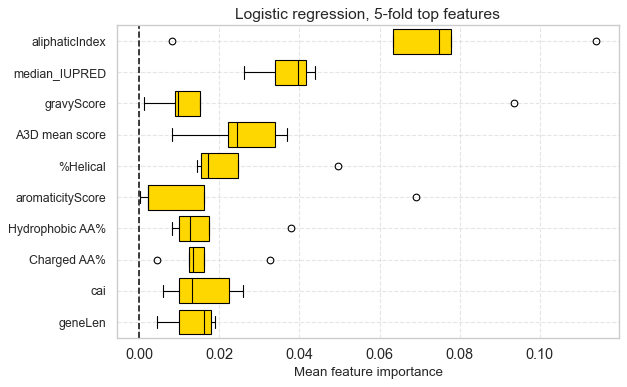

In [24]:
plot_FI(FI)

In [25]:
def corr_features(X, coef= 'spearman', filename= False):
    corr = X.corr(method=coef)
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(26, 17))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True, sep=100)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, linewidths=.5, annot=True)
    plt.yticks(rotation=0) 
    fig.suptitle('Correlation matrix of features', fontsize=15)
    fig.tight_layout()
    if filename:
        fig.savefig(filename, bbox_inches='tight')

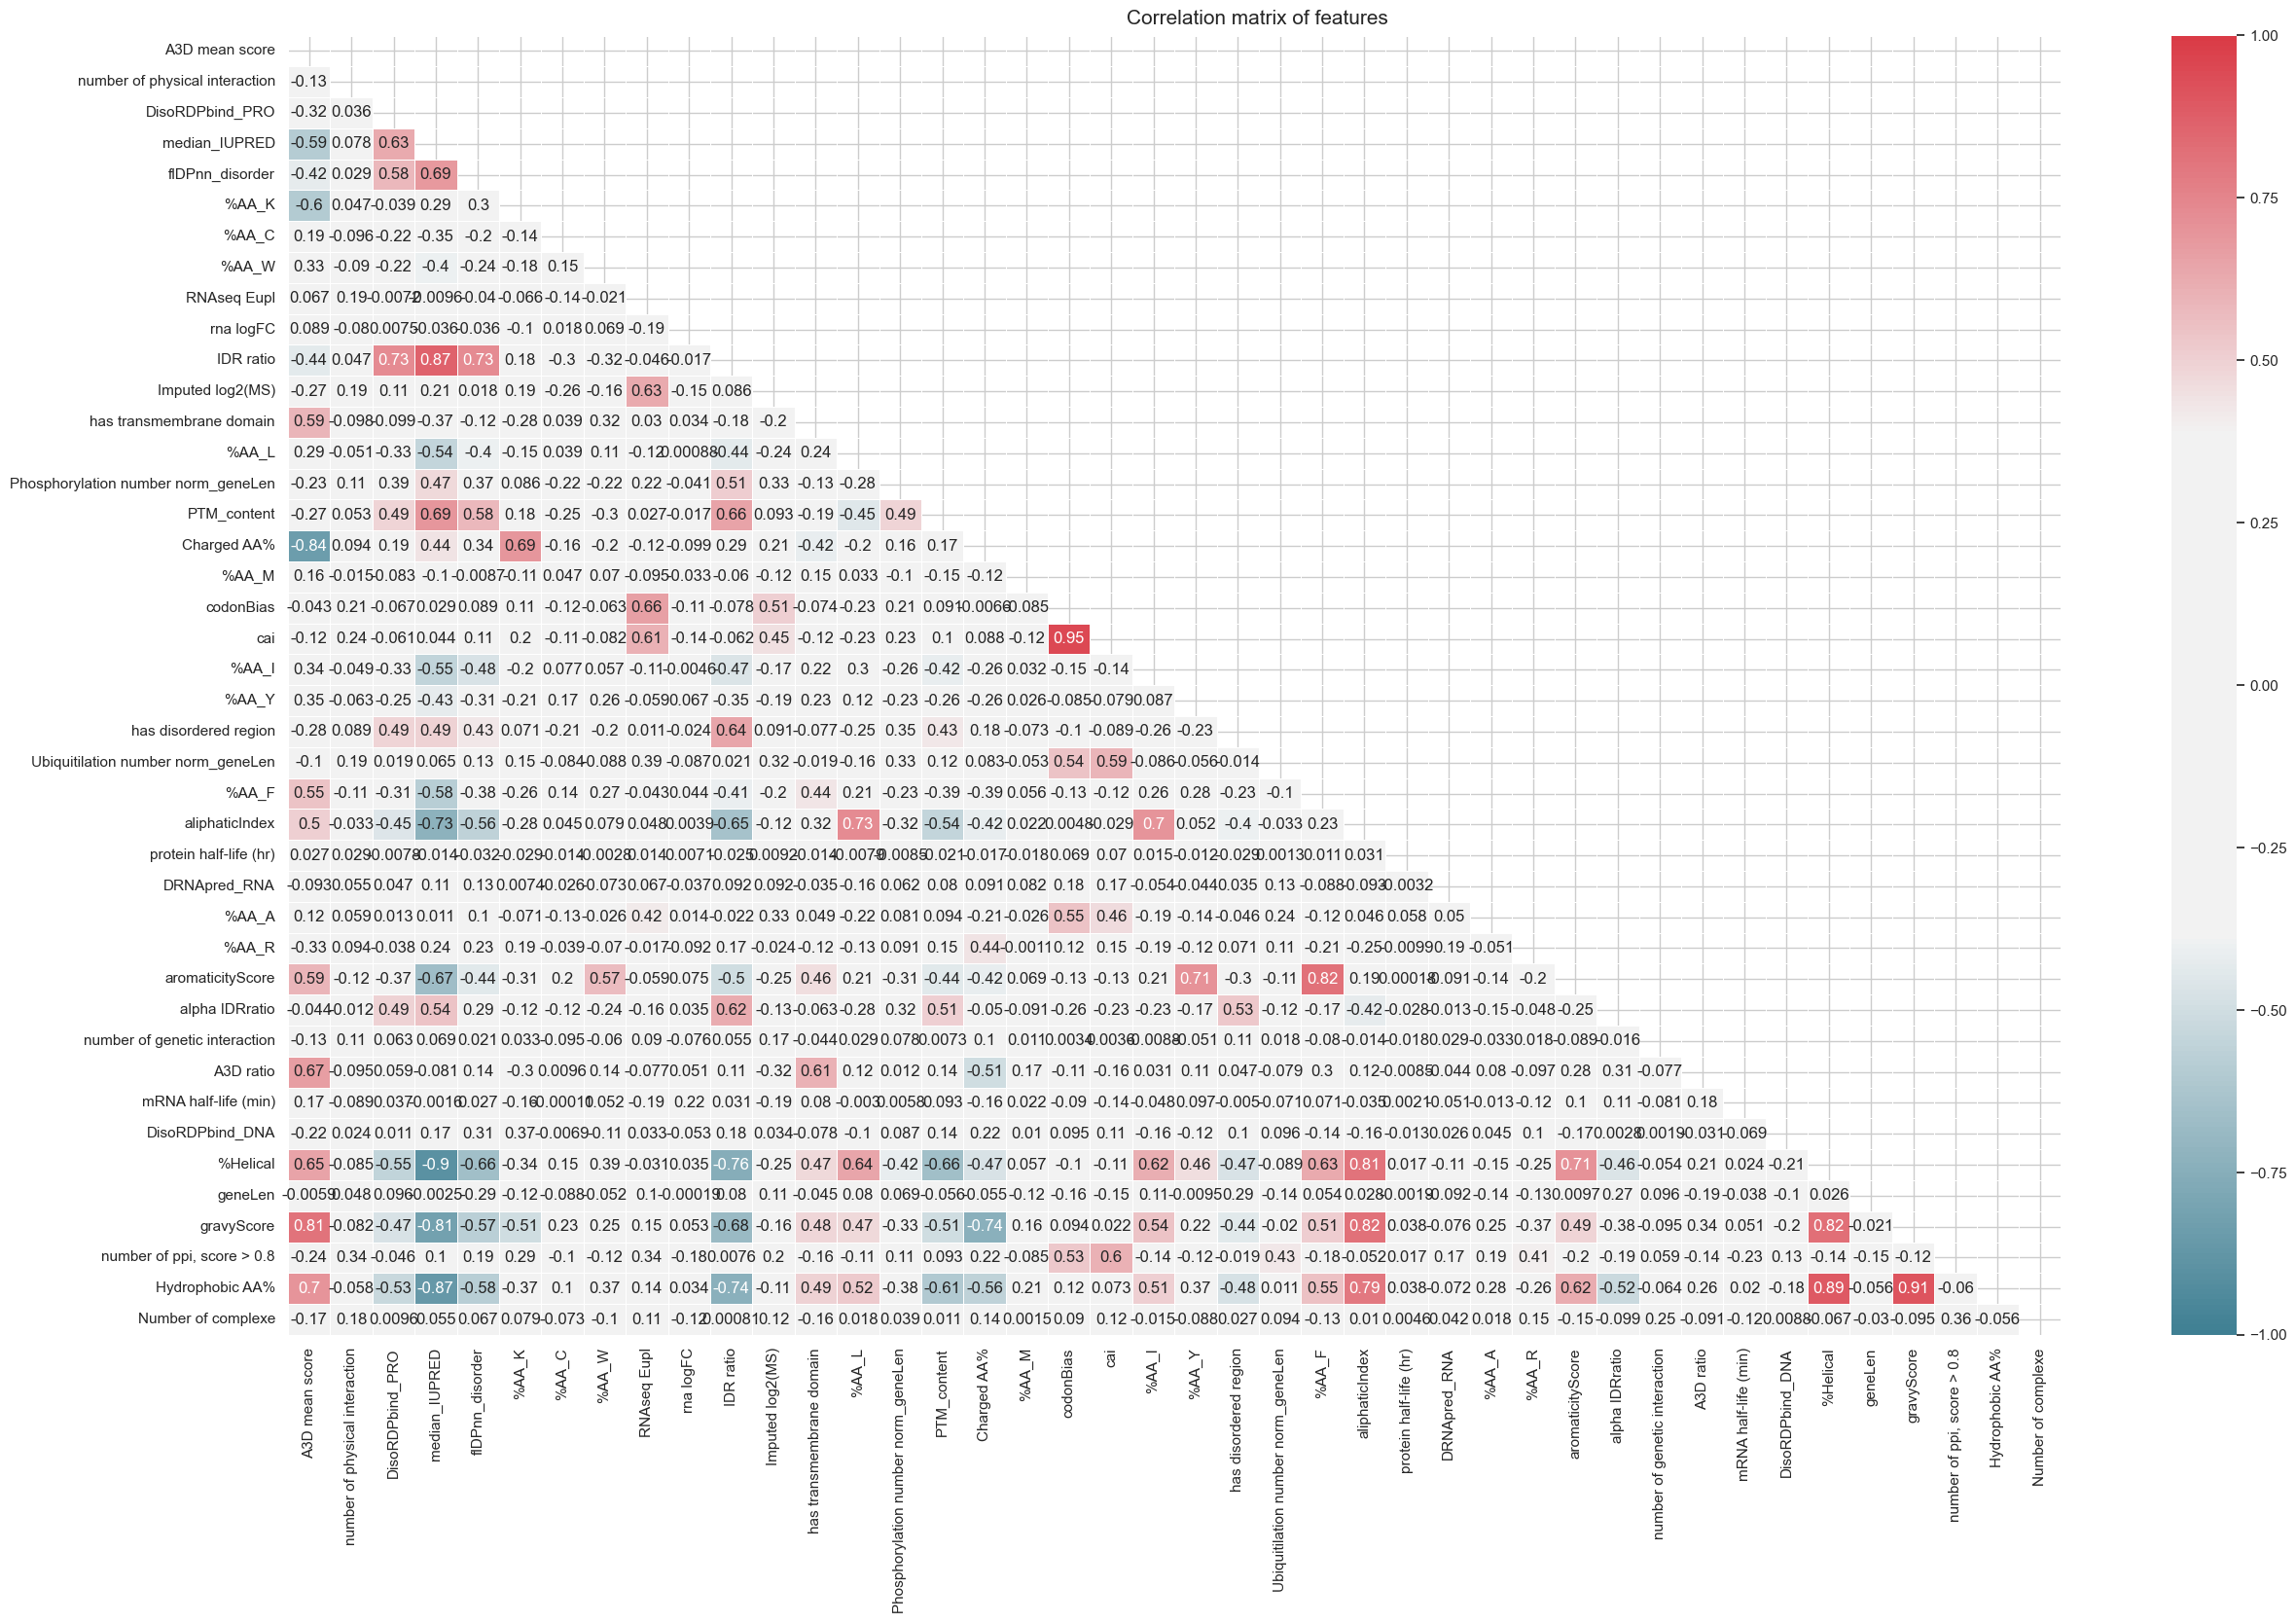

In [26]:
corr_features(df[n], coef= 'pearson', filename= False)

# Dutcher data from the Model fitted on Robinson

In [28]:
dutcher = pd.read_csv('result_datasets/Moby_genes_features.csv', index_col = 0)

In [29]:
q15 = dutcher.logFC.quantile(.15)
# Conditions for genes to drop
c1 = dutcher[dutcher['logFC'] < q15].index
c2 = dutcher[dutcher['FDR'] < 0.05].index 
dutcher_toxic = list(set(c1) & set(c2)) 

In [30]:
df = df.join(DF[['Systematic name']])

In [31]:
df['Dutcher Label'] = 0
df.loc[df['Systematic name'].isin(dutcher_toxic), 'Dutcher Label'] = 1

C:\Users\user\AppData\Local\Temp\ipykernel_14264\1911238444.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Dutcher Label'] = 0


In [32]:
def CV_roc_cross_data(DF, num_F, cat_F, y_F, y2, fig, ax, n_splits, model, color, label_name):
    folds = StratifiedKFold(n_splits,shuffle=True,random_state=17)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    X = DF[num_F+cat_F]
    y = DF[y_F]
    
    for fold, (train_index, valid_index) in enumerate(folds.split(X, y)):
        X_train = X.iloc[train_index]
        X_valid = X.iloc[valid_index]
        y_train = y.iloc[train_index]
        y_valid = y2[valid_index]
        # scaling
        scaler = preprocessing.StandardScaler().fit(X_train[num_F])
        X_train_s = pd.DataFrame(scaler.fit_transform(X_train[num_F]), columns=num_F, index = list(X_train.index))
        X_valid_s = pd.DataFrame(scaler.transform(X_valid[num_F]), columns=num_F, index = list(X_valid.index))

        # merge scaled numerical and categorical
        X_train = pd.concat([X_train_s, X_train[cat_F]], axis=1)
        X_valid = pd.concat([X_valid_s, X_valid[cat_F]], axis=1)

        # fitting
        model.fit(X_train, y_train)
            
        viz = RocCurveDisplay.from_estimator(model, X_valid, y_valid, name=f"ROC fold {fold}",alpha=0,
                lw=1, ax=ax, plot_chance_level=(fold == n_splits - 1))
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
      
        # same aucs calculation as train_model function
        y_pred_valid = model.predict_proba(X_valid)
        # retrieve just the probabilities for the positive class
        y_pred_valid = y_pred_valid[:, 1]
        f, t, thresholds = metrics.roc_curve(np.array(y_valid), y_pred_valid, pos_label=1)
        aucs.append(metrics.auc(f, t))
        

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr,mean_tpr,color=color, label= label_name + r", Mean ROC (AUC = %0.3f $\pm$ %0.3f)" % (mean_auc, std_auc),
        lw=2,alpha=0.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color=color,
        alpha=0.1,
        label=r"$\pm$ std. dev.")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [33]:
X = df.copy()
X.drop(['Systematic name', 'Dutcher Label'], axis=1, inplace=True)
y = df['Label']
ydutcher = df['Dutcher Label']

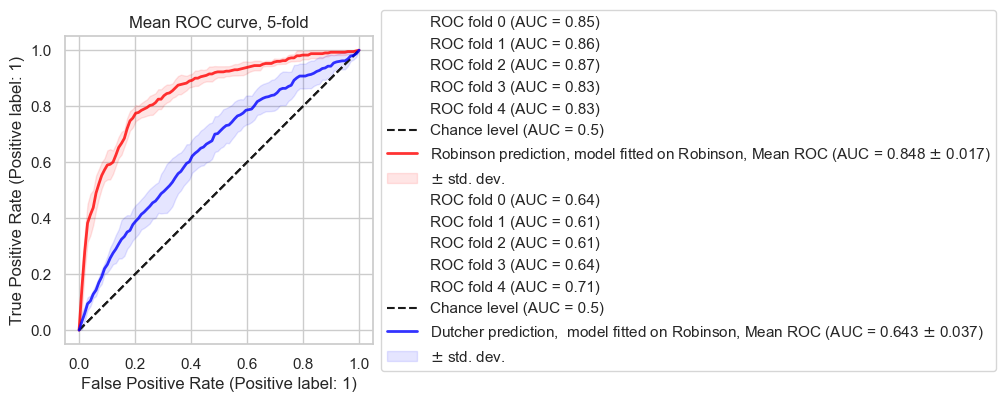

<Figure size 640x480 with 0 Axes>

In [34]:
n = list(set(num_list) & set(X.columns))
c = list(set(X.columns) - set(num_list))
c.remove('Label')
fig, ax = plt.subplots(figsize=(4, 4))
ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Mean ROC curve, 5-fold",
    )
ax.axis("square")

CV_roc_curve(X, n, c, 'Label', fig, ax, 5, classifier, 'red', 'Robinson prediction, model fitted on Robinson')
CV_roc_cross_data(X, n, c, 'Label', ydutcher, fig, ax, 5, classifier, 'blue', 'Dutcher prediction,  model fitted on Robinson')
plt.show()
plt.savefig('plots/ROCcurves_Robinson_common_on_Auguste.pdf')

# Make a model with top features

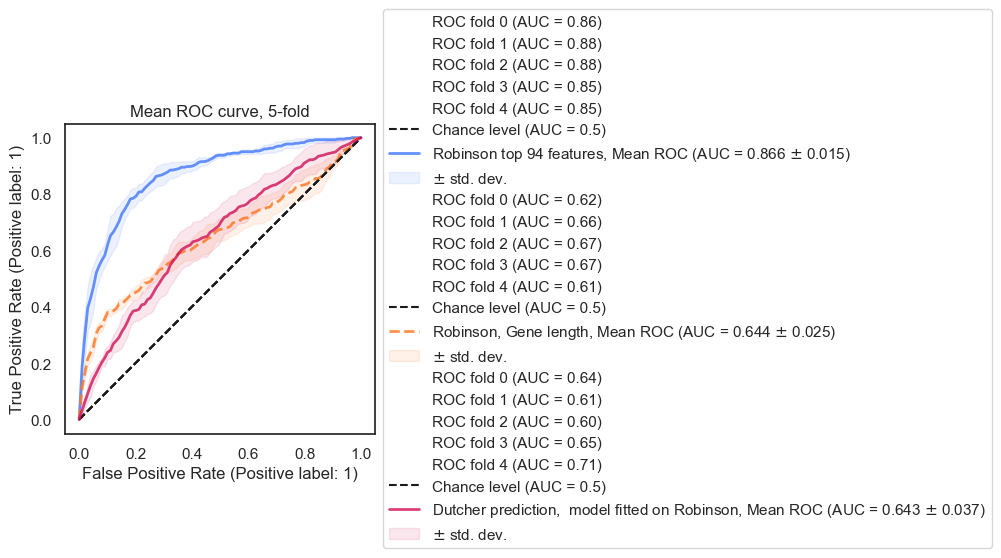

In [35]:
# keep only top feature
coefs = coefs_kfold(X, n, c, 'Label' , 5, classifier)
coefs['abs mean'] = np.abs(coefs['mean'])
coefs.sort_values('abs mean', inplace= True, ascending=False)

n_feat = 94
tmp = set(coefs.head(n_feat).index)
n_short = list(set(n) & tmp)
c_short = list(set(c) & tmp)

classifier = LogisticRegression(max_iter=500, penalty='l2', solver='newton-cholesky', class_weight='balanced')
sns.set_style("white")
fig, ax = plt.subplots(figsize=(4, 8))
ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Mean ROC curve, 5-fold",
    )
ax.axis("square")

a,b = CV_roc_curve(X, n_short, c_short, 'Label', fig, ax, 5, classifier, '#4176FC', 'Robinson top ' + str(n_feat) + ' features')
a,b = CV_roc_curve(X, ['geneLen'], [], 'Label', fig, ax, 5, classifier, '#FF751F', 'Robinson, Gene length', linestyle='dashed')

CV_roc_cross_data(X, n_short, c_short, 'Label', ydutcher, fig, ax, 5, classifier, '#D01157', 'Dutcher prediction,  model fitted on Robinson')
#CV_roc_cross_data(X, ['geneLen'], [], 'Label', ydutcher, fig, ax, 5, classifier, 'limegreen', 'Dutcher, Gene length')
plt.savefig('plots/Robinson_common_Dutcher_fit.pdf')

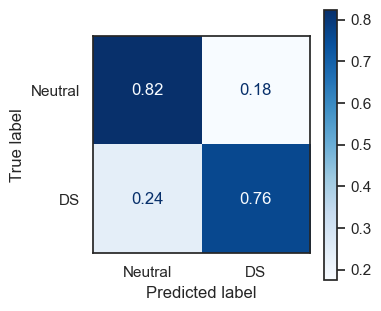

In [36]:
CV_confusion(X, n_short, c_short, 'Label', classifier, 5)
plt.savefig('plots/confusion_matrix_commonDS.pdf')

In [37]:
coefs = coefs_kfold(X, n_short, c_short, 'Label' , 5, classifier)
FI = permutation_importance_kfold(X, n_short, c_short, 'Label' , 5, classifier)

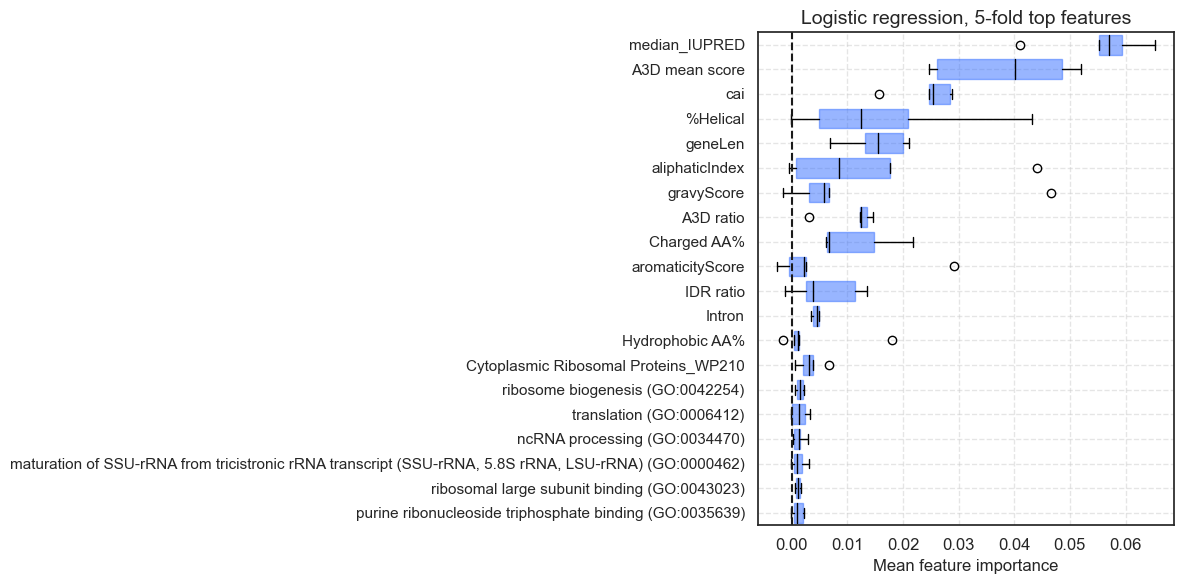

In [38]:
plot_FI_coef_col(FI, coefs, f_display = 20, figsize=(12,6), c1 = '#336DFF', c2 = '#336DFF', savefig='plots/RobinsonCommon_Logit_72F_feature_importance_top20_boxplot_presentation.pdf')

In [39]:
FI.sort_values('mean', inplace=True, ascending=False)

C:\Users\user\AppData\Local\Temp\ipykernel_14264\2721363285.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp.sort_values('mean', inplace=True)


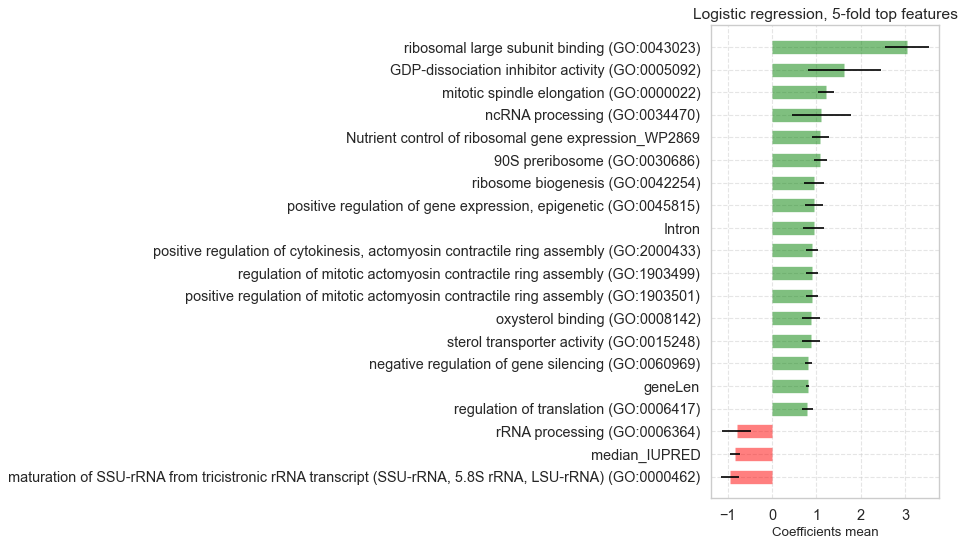

In [40]:
plot_coefs(coefs, display_fit = 20, dim=(12,7)) 

In [41]:
cat_list = list(set(X.columns) - set(num_list))
# For Robinson, we aren't working with logFC, I cannot do a wilcoxon test with 2 categorical column
# Just do a Spearman correlation
corr = X[cat_list].corr(method='spearman')
# That confirm that all enrichment are for the common DS, make sense beacuse fisher test

In [42]:
tmp_FI = FI.copy()
tmp_FI = tmp_FI.join(num_ranksum)

In [43]:
tmp_FI['Statistic'] = tmp_FI['Statistic'].fillna(1)

In [44]:
coefs.rename(columns={'mean': 'coef mean'}, inplace=True)

In [45]:
tmp_FI = tmp_FI.join(coefs[['coef mean']])

In [46]:
tmp_FI['sign wilc'] = 'N'
tmp_FI.loc[tmp_FI['Statistic'] > 0, 'sign wilc'] = 'T'

tmp_FI['sign coef'] = 'N'
tmp_FI.loc[tmp_FI['coef mean'] > 0, 'sign coef'] = 'T'

In [47]:
tmp_FI.sort_values('mean', ascending=False).head(25).to_excel('result_datasets/Robinson_Permutation_importance_signs.xlsx')

In [48]:
tmp_FI.sort_values('mean', ascending=False).head(25)

,0,1,2,3,4,mean,std,p-value,Statistic,FDR bh,coef mean,sign wilc,sign coef
median_IUPRED,0.065317,0.059278,0.040958,0.056950,0.055162,0.055533,0.008054,2.507189e-09,5.960987,1.002876e-08,-0.838629,T,N
A3D mean score,0.051923,0.024730,0.048583,0.026113,0.040081,0.038286,0.011200,4.305252e-10,-6.242539,2.044995e-09,-0.625561,N,N
cai,0.028509,0.028711,0.024629,0.015756,0.025405,0.024602,0.004713,6.537960e-39,13.047834,1.656283e-37,0.688906,T,T
%Helical,0.043219,-0.000067,0.012517,0.020918,0.004960,0.016309,0.015210,1.296363e-11,-6.769044,7.578738e-11,0.214156,N,T
geneLen,0.020007,0.015553,0.013158,0.006849,0.021120,0.015337,0.005140,3.659793e-21,9.441929,3.476803e-20,0.803384,T,T
aliphaticIndex,0.044062,-0.000540,0.017578,0.008468,0.000742,0.014062,0.016336,6.462670e-05,-3.995248,1.637210e-04,-0.256685,N,N
gravyScore,0.006646,0.046660,0.003070,-0.001586,0.005769,0.012112,0.017510,1.509454e-05,-4.327304,3.955809e-05,-0.257300,N,N
A3D ratio,0.013529,0.012449,0.012179,0.003104,0.014676,0.011188,0.004137,1.033338e-05,-4.410077,2.804773e-05,0.297781,N,T
Charged AA%,0.021795,0.014777,0.006680,0.006208,0.006377,0.011167,0.006224,2.698860e-02,2.211683,4.883651e-02,-0.390197,T,N
aromaticityScore,0.029217,-0.000472,0.002193,-0.002699,0.002632,0.006174,0.011682,2.826602e-09,-5.941364,1.074109e-08,-0.124433,N,N


In [49]:
coefs.head(15)

,0,1,2,3,4,coef mean,std,colors,abs mean
ribosomal large subunit binding (GO:0043023),3.266295,3.289129,3.700837,2.656289,2.315442,3.045598,0.494377,green,3.045598
GDP-dissociation inhibitor activity (GO:0005092),1.993633,2.052329,-0.016278,1.979249,2.163594,1.634505,0.827939,green,1.634505
mitotic spindle elongation (GO:0000022),1.432143,1.053586,1.302912,0.974052,1.339787,1.220496,0.175733,green,1.220496
ncRNA processing (GO:0034470),-0.201714,1.521416,1.543154,1.457154,1.257706,1.115543,0.666282,green,1.115543
Nutrient control of ribosomal gene expression_WP2869,1.083314,0.761980,1.127603,1.160498,1.337332,1.094145,0.187143,green,1.094145
90S preribosome (GO:0030686),1.235596,1.174812,0.957677,1.232498,0.860350,1.092187,0.154221,green,1.092187
"maturation of SSU-rRNA from tricistronic rRNA transcript (SSU-rRNA, 5.8S rRNA, LSU-rRNA) (GO:0000462)",-0.719066,-1.120376,-0.828883,-1.241498,-0.851596,-0.952284,0.195784,red,0.952284
ribosome biogenesis (GO:0042254),1.337389,0.857689,1.059419,0.795271,0.698655,0.949685,0.227015,green,0.949685
"positive regulation of gene expression, epigenetic (GO:0045815)",1.011510,0.965478,0.994714,0.557061,1.175521,0.940857,0.205361,green,0.940857
Intron,1.020158,0.547137,0.929332,1.301226,0.900642,0.939699,0.242038,green,0.939699


In [50]:
# Compare features overlap for Duplicaton screen and 
dut = ['regulation of cell cycle process (GO:0010564)',
 'Cell cycle',
 'Sphingolipid Metabolism_WP370',
 'instabilityIndex',
 'regulation of mitotic cell cycle (GO:0007346)',
 'ASAquick_buried',
 'prion_inheritance',
 'has disordered region',
 'DisoRDPbind_PRO',
 'Phosphorylation number norm_geneLen',
 'is essential',
 'geneLen']

rob = list(FI.index)

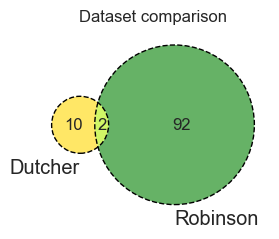

In [51]:
plt.figure(figsize = (3, 3))
venn2([set(dut), set(rob)], ('Dutcher', 'Robinson'), set_colors=("gold", 
                             "green"),alpha=0.6)
venn2_circles([set(dut), set(rob)],  
              linestyle="dashed", linewidth=1) 
plt.title('Dataset comparison')
plt.show()